# Iris KNN Classifier Notebook

K近傍法 (K-Nearest Neighbors; KNN) によるアヤメ品種の分類を行い、特徴量の組み合わせや近傍数 \(k\) の違いによる性能を評価します。


In [2]:
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sns.set_theme(style="whitegrid")


## データ読み込み


In [3]:
def find_data_path(filename: str = "iris.csv", search_depth: int = 4) -> Path:
    current = Path.cwd().resolve()
    candidates = [current / filename]
    candidates.extend(parent / filename for parent in current.parents[:search_depth])

    for path in candidates:
        if path.exists():
            return path

    raise FileNotFoundError(
        f"Could not find {filename}. Checked: {[str(path) for path in candidates]}"
    )


def load_iris_dataframe() -> pd.DataFrame:
    path = find_data_path()
    df = pd.read_csv(path)
    renamed_columns = {
        "sepal.length (cm)": "sepal.length",
        "sepal.width (cm)": "sepal.width",
        "petal.length (cm)": "petal.length",
        "petal.width (cm)": "petal.width",
    }
    df = df.rename(columns=renamed_columns)
    species_map = {0: "setosa", 1: "versicolor", 2: "virginica"}
    df["species"] = df["target"].map(species_map)
    return df


df_iris = load_iris_dataframe()
df_iris.head()


,sepal.length,sepal.width,petal.length,petal.width,target,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


## 特徴量選択の設定


In [4]:
FEATURE_MODES: dict[str, list[str]] = {
    "all": ["sepal.length", "sepal.width", "petal.length", "petal.width"],
    "sepal": ["sepal.length", "sepal.width"],
    "petal": ["petal.length", "petal.width"],
}

FEATURE_MODE = "all"  # "all", "sepal", "petal" から選択
CUSTOM_FEATURES: list[str] | None = None  # 例: ["sepal.length", "petal.length"]
K_VALUES = [1, 3, 5, 10]
TEST_SIZE = 0.2
RANDOM_STATE = 42


def resolve_feature_names(feature_mode: str, custom_features: list[str] | None) -> list[str]:
    if custom_features:
        return custom_features
    try:
        return FEATURE_MODES[feature_mode]
    except KeyError:
        available = ", ".join(FEATURE_MODES)
        raise ValueError(f"Unknown feature_mode '{feature_mode}'. Choose from: {available}")


## 評価用ユーティリティ


In [5]:
@dataclass
class KNNResult:
    k: int
    accuracy: float
    model: KNeighborsClassifier
    pipeline: any
    y_test: np.ndarray
    y_pred: np.ndarray


def evaluate_knn(
    data: pd.DataFrame,
    feature_names: list[str],
    k_values: list[int],
    test_size: float = 0.2,
    random_state: int = 42,
) -> tuple[list[KNNResult], tuple[np.ndarray, np.ndarray]]:
    X = data[feature_names].to_numpy()
    y = data["species"].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y,
    )

    results: list[KNNResult] = []

    for k in k_values:
        pipeline = make_pipeline(
            StandardScaler(),
            KNeighborsClassifier(n_neighbors=k),
        )
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        knn_model = pipeline.named_steps["kneighborsclassifier"]
        results.append(
            KNNResult(
                k=k,
                accuracy=accuracy,
                model=knn_model,
                pipeline=pipeline,
                y_test=y_test,
                y_pred=y_pred,
            )
        )

    return results, (X, y)


## KNNモデルの学習と評価


Using features: ['sepal.length', 'sepal.width', 'petal.length', 'petal.width']
k =  1 | accuracy = 0.967


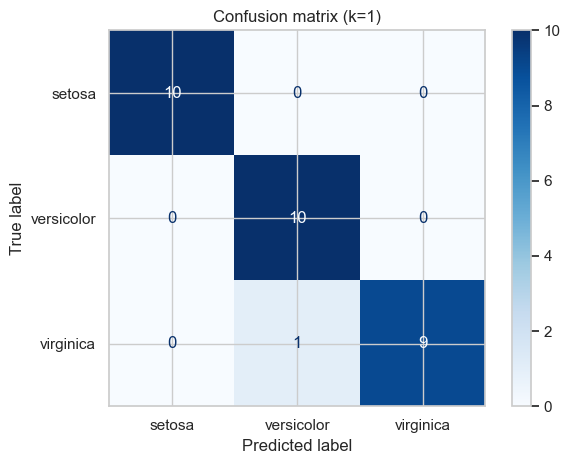

k =  3 | accuracy = 0.933


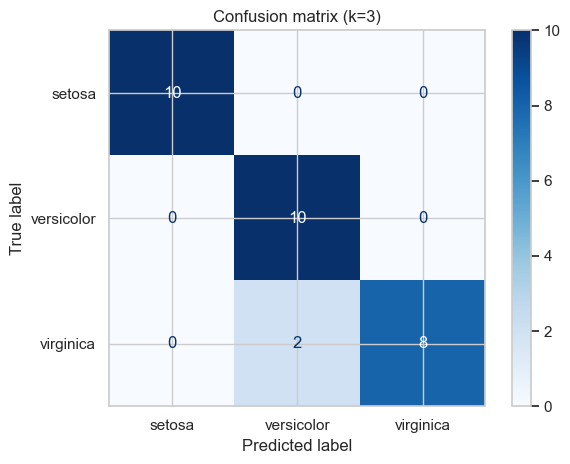

k =  5 | accuracy = 0.933


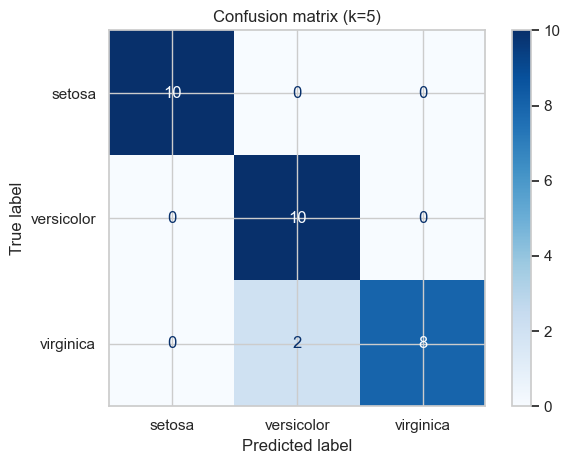

k = 10 | accuracy = 0.967


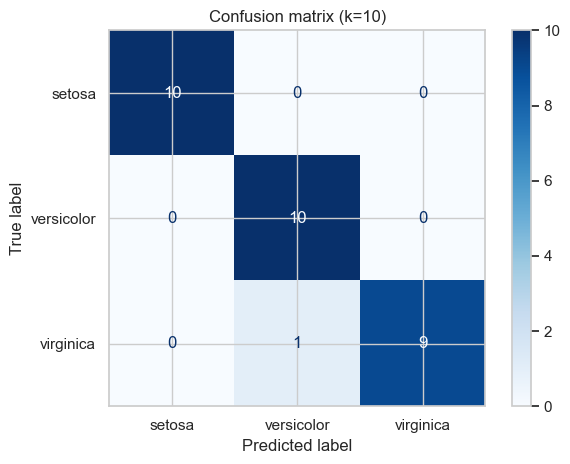

In [6]:
feature_names = resolve_feature_names(FEATURE_MODE, CUSTOM_FEATURES)
print(f"Using features: {feature_names}")
results, (X_all, y_all) = evaluate_knn(
    df_iris,
    feature_names=feature_names,
    k_values=K_VALUES,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

for result in results:
    print(f"k = {result.k:2d} | accuracy = {result.accuracy:.3f}")
    ConfusionMatrixDisplay.from_predictions(
        result.y_test,
        result.y_pred,
        display_labels=sorted(np.unique(y_all)),
        cmap="Blues",
        normalize=None,
    )
    plt.title(f"Confusion matrix (k={result.k})")
    plt.tight_layout()
    plt.show()


## 2特徴量の場合の決定境界可視化


In [7]:
def plot_decision_boundary(
    pipeline,
    X: np.ndarray,
    y: np.ndarray,
    feature_names: list[str],
    step: float = 0.02,
    title: str | None = None,
):
    if X.shape[1] != 2:
        raise ValueError("Decision boundary can only be drawn for 2D feature spaces.")

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, step),
        np.arange(y_min, y_max, step),
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    predictions = pipeline.predict(grid)
    classes = sorted(np.unique(y))
    class_to_index = {label: index for index, label in enumerate(classes)}
    zz = np.vectorize(class_to_index.get)(predictions).reshape(xx.shape)

    cmap = ListedColormap(sns.color_palette("pastel", n_colors=len(classes)))

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.contourf(xx, yy, zz, cmap=cmap, alpha=0.5)

    palette = sns.color_palette("deep", n_colors=len(classes))
    for label, color in zip(classes, palette):
        mask = y == label
        ax.scatter(
            X[mask, 0],
            X[mask, 1],
            label=label,
            edgecolor="black",
            color=color,
            s=60,
        )

    xlabel = feature_names[0].replace(".", " ").title()
    ylabel = feature_names[1].replace(".", " ").title()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title or "KNN decision boundary")
    ax.legend(title="Species")
    plt.tight_layout()
    return ax


In [8]:
if len(feature_names) == 2:
    best_result = max(results, key=lambda item: item.accuracy)
    plot_decision_boundary(
        pipeline=best_result.pipeline,
        X=X_all,
        y=y_all,
        feature_names=feature_names,
        title=f"Decision boundary (k={best_result.k})",
    )
    plt.show()
else:
    print("Decision boundary visualization is skipped because more than 2 features were selected.")


Decision boundary visualization is skipped because more than 2 features were selected.
